In [2]:
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torchinfo
from tqdm import tqdm

In [3]:
# data_dir = "/Users/trevoryu/Code/syde_599/data/norm_fog_data/"
data_dir = "D:/SYDE599/norm_fog_data/"

data_files = glob.glob(data_dir + "*.csv")
len(data_files)

56

In [4]:
data = np.loadtxt(data_files[0], delimiter=",", skiprows=1)
data.shape

(180501, 32)

# Load the data

In [16]:
WINDOW_SIZE = 512

train_X = []
train_Y = []
test_X = []
test_Y = []

for file in tqdm(data_files):
    path_parts = file.split('\\')
    patient_num = path_parts[-1].split('_')[0]

    data = np.loadtxt(file, delimiter=",", skiprows=1)
    # Timestamp is in col 0, labels are in col 1
    # Data is in cols 2 to end
    y = data[:, 1]
    x = data[:, 2:]

    # Split into non-overlapping windows
    # Don't use the last bit of data that doesn't fill a whole window
    n_windows = y.size // WINDOW_SIZE
    end = WINDOW_SIZE * n_windows
    x = x[:end, :]  # (n_samples, d)
    y = y[:end]

    # Reshape into (n_windows, window_size, d)
    x = x.reshape(n_windows, WINDOW_SIZE, -1)
    y = y.reshape(n_windows, WINDOW_SIZE)
    
    if patient_num in ('001', '005', '007'):
        test_X.append(x)
        test_Y.append(y)
    else:
        train_X.append(x)
        train_Y.append(y)

In [17]:
train_X = np.concatenate(train_X, axis=0)
train_Y = np.concatenate(train_Y, axis=0)

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)

# Build dataset and dataloader

In [18]:
class FoGDataset(torch.utils.data.Dataset):
    def __init__(self, data_x, data_y):
        """
        Parameters:
        -----------
        data_x: np.ndarray of shape (num_samples, window_size, num_features) which contains data features for FoG
        data_y: np.ndarray of shape (num_samples, window_size) which contains binary labels for FoG
        """
        super().__init__()
        self.data_x = data_x
        self.data_y = data_y

    def _reduce_labels(self, y):
        """If there is a 1 in the label, then return 1"""
        return np.any(y == 1, axis=-1).astype(int)

    def __len__(self):
        return self.data_x.shape[0]

    def __getitem__(self, index):
        """Returns tuple of (data, label) at index"""
        inputs = self.data_x[index, :, :]
        labels = self.data_y[index, :]
        labels = self._reduce_labels(labels)
        return torch.tensor(inputs, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)


In [19]:
train_dataset = FoGDataset(train_X, train_Y)
test_dataset = FoGDataset(test_X, test_Y)


BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Define model

In [59]:
class LinearModel(nn.Module):
    def __init__(self, in_features=30, output_dim=1):
        super().__init__()

        # Fully connected layer
        self.fc = nn.Linear(in_features*WINDOW_SIZE, output_dim)

    def forward(self, x):
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(x.flatten(start_dim=-2))
        return torch.sigmoid(out)

In [43]:
model = LinearModel()
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LinearModel                              --
├─Linear: 1-1                            31
Total params: 31
Trainable params: 31
Non-trainable params: 0

# Training

In [62]:
def train(model, dataloader, optimizer, criterion, epoch, logging_steps=20, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.train()
    total_loss = 0
    correct = 0
    loss_history = []
    for i, (inputs, targets) in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        outputs = outputs.flatten()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss
        loss_history.append(loss.item())
        preds = torch.round(torch.sigmoid(outputs))
        correct += torch.sum(preds == targets).detach().cpu()

        if i % logging_steps == 0:
            print(f'Epoch: {epoch} ({i}/{len(dataloader)}) Training loss: {loss}')

    accuracy = correct / (dataloader.batch_size * len(dataloader))
    print(f'Epoch {epoch} done. Training loss: {total_loss/len(dataloader)} Training accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader), loss_history

In [63]:
def evaluate(model, dataloader, criterion, epoch, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(dataloader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            outputs = outputs.flatten()
            loss = criterion(outputs, targets)

            total_loss += loss
            preds = torch.round(torch.sigmoid(outputs))
            correct += torch.sum(preds == targets).detach().cpu()

        accuracy = correct / (dataloader.batch_size * len(dataloader))
        print(f'Epoch {epoch} done. Eval loss: {total_loss/len(dataloader)} Eval accuracy: {accuracy}')
    return accuracy, total_loss/len(dataloader)

In [64]:
model = LinearModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.BCEWithLogitsLoss()
EPOCHS = 5

In [65]:
loss_history = []
train_acc_history = []
eval_acc_history = []
eval_loss_history = []
for epoch in range(EPOCHS):
    train_acc, train_loss, history = train(model, train_loader, optimizer, criterion, epoch)
    eval_acc, eval_loss = evaluate(model, test_loader, criterion, epoch)
    
    loss_history.extend(history)
    eval_loss_history.append(eval_loss)
    train_acc_history.append(train_acc)
    eval_acc_history.append(eval_acc)
    

7it [00:00, 69.32it/s]

Epoch: 0 (0/163) Training loss: 0.7227836847305298


29it [00:00, 66.91it/s]

Epoch: 0 (20/163) Training loss: 0.7651460766792297


43it [00:00, 54.77it/s]

Epoch: 0 (40/163) Training loss: 0.6897425651550293


65it [00:01, 40.44it/s]

Epoch: 0 (60/163) Training loss: 0.6836885213851929


90it [00:01, 56.54it/s]

Epoch: 0 (80/163) Training loss: 0.6938508152961731


112it [00:02, 62.80it/s]

Epoch: 0 (100/163) Training loss: 0.7515073418617249


133it [00:02, 63.84it/s]

Epoch: 0 (120/163) Training loss: 0.6475903391838074


147it [00:02, 64.33it/s]

Epoch: 0 (140/163) Training loss: 0.6710330843925476


163it [00:02, 56.15it/s]


Epoch: 0 (160/163) Training loss: 0.7350093722343445
Epoch 0 done. Training loss: 0.7139367461204529 Training accuracy: 0.47018787264823914


27it [00:00, 59.34it/s]


Epoch 0 done. Eval loss: 0.7518759965896606 Eval accuracy: 0.36863425374031067


6it [00:00, 53.57it/s]

Epoch: 1 (0/163) Training loss: 0.7189335823059082


32it [00:00, 58.86it/s]

Epoch: 1 (20/163) Training loss: 0.6206451058387756


50it [00:00, 54.78it/s]

Epoch: 1 (40/163) Training loss: 0.6900747418403625


67it [00:01, 48.50it/s]

Epoch: 1 (60/163) Training loss: 0.7345691919326782


91it [00:01, 51.10it/s]

Epoch: 1 (80/163) Training loss: 0.7820461392402649


109it [00:02, 53.30it/s]

Epoch: 1 (100/163) Training loss: 0.688174843788147


127it [00:02, 54.70it/s]

Epoch: 1 (120/163) Training loss: 0.6714679598808289


151it [00:02, 51.47it/s]

Epoch: 1 (140/163) Training loss: 0.6902350187301636


163it [00:03, 51.24it/s]


Epoch: 1 (160/163) Training loss: 0.6376318335533142
Epoch 1 done. Training loss: 0.6842712759971619 Training accuracy: 0.47584354877471924


27it [00:00, 51.33it/s]


Epoch 1 done. Eval loss: 0.7498000860214233 Eval accuracy: 0.36921295523643494


7it [00:00, 64.22it/s]

Epoch: 2 (0/163) Training loss: 0.6284036636352539


31it [00:00, 74.31it/s]

Epoch: 2 (20/163) Training loss: 0.707367479801178


55it [00:00, 71.67it/s]

Epoch: 2 (40/163) Training loss: 0.6747652292251587


70it [00:01, 67.14it/s]

Epoch: 2 (60/163) Training loss: 0.731109619140625


93it [00:01, 67.52it/s]

Epoch: 2 (80/163) Training loss: 0.6209670305252075


115it [00:01, 67.83it/s]

Epoch: 2 (100/163) Training loss: 0.6812378764152527


129it [00:01, 67.88it/s]

Epoch: 2 (120/163) Training loss: 0.6765040159225464


151it [00:02, 63.70it/s]

Epoch: 2 (140/163) Training loss: 0.6901307106018066


163it [00:02, 67.13it/s]


Epoch: 2 (160/163) Training loss: 0.6943720579147339
Epoch 2 done. Training loss: 0.6747346520423889 Training accuracy: 0.4779524505138397


27it [00:00, 86.54it/s]


Epoch 2 done. Eval loss: 0.7468929290771484 Eval accuracy: 0.36921295523643494


15it [00:00, 73.84it/s]

Epoch: 3 (0/163) Training loss: 0.6774924397468567


31it [00:00, 69.46it/s]

Epoch: 3 (20/163) Training loss: 0.6679727435112


47it [00:00, 69.87it/s]

Epoch: 3 (40/163) Training loss: 0.6609696745872498


70it [00:01, 60.74it/s]

Epoch: 3 (60/163) Training loss: 0.6704519391059875


89it [00:01, 53.70it/s]

Epoch: 3 (80/163) Training loss: 0.6516345143318176


107it [00:01, 51.12it/s]

Epoch: 3 (100/163) Training loss: 0.6765617728233337


125it [00:02, 50.55it/s]

Epoch: 3 (120/163) Training loss: 0.6734815835952759


147it [00:02, 42.95it/s]

Epoch: 3 (140/163) Training loss: 0.6070482730865479


163it [00:03, 54.32it/s]


Epoch: 3 (160/163) Training loss: 0.6419141292572021
Epoch 3 done. Training loss: 0.6684213876724243 Training accuracy: 0.4804447889328003


27it [00:00, 57.69it/s]


Epoch 3 done. Eval loss: 0.7441253066062927 Eval accuracy: 0.37037035822868347


5it [00:00, 45.04it/s]

Epoch: 4 (0/163) Training loss: 0.6565930247306824


28it [00:00, 50.48it/s]

Epoch: 4 (20/163) Training loss: 0.6524419784545898


47it [00:00, 52.32it/s]

Epoch: 4 (40/163) Training loss: 0.673315167427063


71it [00:01, 51.13it/s]

Epoch: 4 (60/163) Training loss: 0.6547504663467407


89it [00:01, 53.10it/s]

Epoch: 4 (80/163) Training loss: 0.6819667816162109


107it [00:02, 52.58it/s]

Epoch: 4 (100/163) Training loss: 0.7240675687789917


131it [00:02, 52.40it/s]

Epoch: 4 (120/163) Training loss: 0.7099040746688843


149it [00:02, 51.95it/s]

Epoch: 4 (140/163) Training loss: 0.6431823372840881


163it [00:03, 51.57it/s]


Epoch: 4 (160/163) Training loss: 0.6490151882171631
Epoch 4 done. Training loss: 0.6633855700492859 Training accuracy: 0.48370400071144104


27it [00:00, 47.95it/s]

Epoch 4 done. Eval loss: 0.7402486205101013 Eval accuracy: 0.37037035822868347


In [66]:
import matplotlib.pyplot as plt

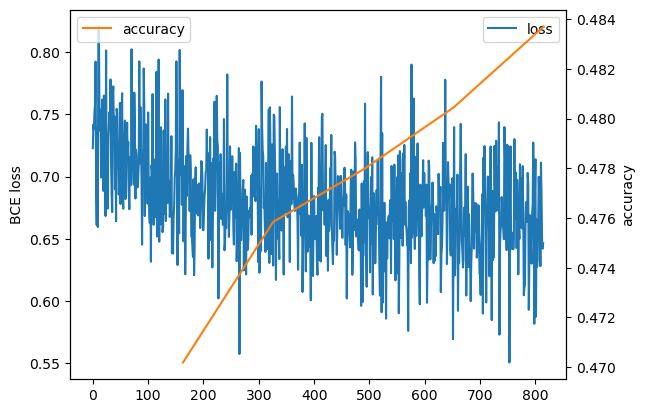

In [67]:
xs = np.arange(len(train_loader), len(loss_history) + len(train_loader), len(train_loader))

plt.plot(loss_history, label="loss")
plt.ylabel("BCE loss")
plt.legend()
plt.twinx()
plt.plot(xs, train_acc_history, label="accuracy", c="C1")
plt.ylabel("accuracy")
plt.legend()
plt.show()

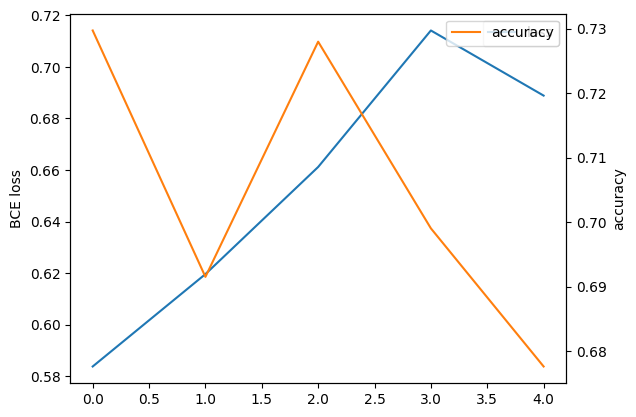

In [ ]:
eval_loss_history = [x.cpu() for x in eval_loss_history]
plt.plot(eval_loss_history, label="loss")
plt.legend()
plt.ylabel("BCE loss")
plt.twinx()
plt.plot(eval_acc_history, c="C1", label="accuracy")
plt.ylabel("accuracy")
plt.legend()
plt.show()